<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Statistics With Baseball Data: Priors and Posteriors

_Authors: Kiefer Katovich (SF)_

---

Let’s review the general set up for Bayesian modeling. We have:

### $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)}{P(\;data\;)} P\left(\;model\;\right)$$

This is the diachronic interpretation of Bayes' theorem.

It can also be written as:

### $$posterior \propto likelihood \cdot prior$$

Here, the posterior is an update of our prior belief given the data observed.

## Bayesian Analysis of Batting Averages

---

Load in the simple batting average data for players below. There are just four fields in the data set: the player's name, their times at bat, their hits, and their batting average.

> *Note: [This section of the lab is a partial replication of this exercise in R, if you're interested](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/). Here, we took out the empirical Bayes section because it's not technically a correct interpretation of Bayesian statistical analysis.*

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns


%matplotlib inline

In [2]:
data = pd.read_csv('career_hits.csv')

In [8]:
data.describe()

,hits,at_bat,average
count,9429.00000,9429.000000,9429.000000
mean,341.55605,1280.125040,0.224995
std,550.01369,1956.563564,0.091421
min,0.00000,1.000000,0.000000
25%,8.00000,41.000000,0.200000
50%,70.00000,306.000000,0.241803
75%,438.00000,1719.000000,0.266667
max,4256.00000,14053.000000,1.000000


### 1) Find the top and bottom three hitters according to their average.

What is wrong with using the average to find the three best and worst hitters?

In [9]:
data.sort_values('average', ascending=False).head(3)

,name,hits,at_bat,average
5853,John Mohardt,1,1,1.0
9303,Al Wright,1,1,1.0
359,Jeff Banister,1,1,1.0


In [10]:
data.sort_values('average', ascending=False).tail(3)

,name,hits,at_bat,average
988,Robert Brown,0,9,0.0
1774,Pete Cote,0,1,0.0
2717,John Flannery,0,2,0.0


### 2) Set up a prior distribution to represent our belief about batting average.

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260.

**Let's make it simple and say that our prior belief is that, out of 100 at-bats, we’ve seen 26 hits. Set up a beta distribution with `alpha=27` and `beta=75`. Plot it with the function from above.**

This is our distribution of beliefs on the batting average (probability of hitting while at bat) for MLB players.

In [12]:
# Define our alpha and beta parameters:
a = 27
b = 75
x = np.linspace(0, 1, 100)

In [23]:
# make alpha from the number of successes
def alphize(k):
    return k + 1

# make beta from the number of successes and trials
def betize(n, k):
    return (n-k+1)

In [21]:
def plot_beta(a, b):
    # Generate 100 x values in the appropriate
    # range to use for plotting:
    x = np.linspace(0, 1, 100)

    # Generate line plot.
    plt.plot(x, beta(a,b).pdf(x),
            'b', lw=2)

    # Plot customization:
    plt.ylabel('Density', fontsize = 14)
    plt.xlim((0,1))
    plt.xlabel('$p$ probability of getting a hit at bat', fontsize = 14)
    plt.title(fr'Beta($\alpha={a}$,$\beta={b}$)', fontsize = 18);

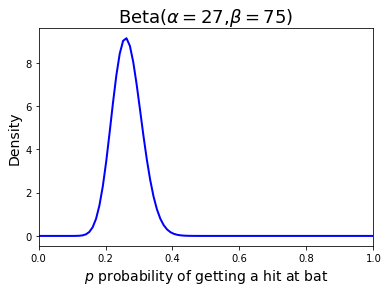

In [22]:
plot_beta(a, b)

### 3) Calculate the maximum a posteriori (MAP) estimate of players' batting averages.

The maximum a posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior beta distribution we get from updating our prior distribution with their at bats and hits.

---

> *Note: For an additional overview of the math behind updating the beta distribution posterior and conjugate priors, ([check out this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/)).*

We need to update our beta distribution’s prior belief about batting averages with a player's at-bat and hit information to get a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution, the update is just a matter of adding in our new observations to the alpha and beta parameters, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits+1, prior_misses+1)
    beta_posterior = Beta(prior_hits + n_nits + 1, prior_misses + n_misses + 1)
    
> **Note:** This process will also be useful in the context of A/B testing, which we’ll look at later on.

For each player, update the prior to the posterior distribution and calculate the mode of the distribution. The mode of a beta distribution is conveniently defined as:

### $$ \frac{\alpha - 1}{\alpha + \beta -2} $$

Which means we don't even need to use SciPy's beta distribution function. Just calculate the new alpha (hits) and beta (misses) for each player's posterior beta distribution and plug them into the formula above to get the MAP estimate of batting the average.

In [24]:
def MAP(hits, at_bat):
    return ((hits+alphize(26)-1)/(hits+alphize(26)+at_bat-hits+betize(100, 26)))

In [27]:
MAP(data.iloc[55,1], data.iloc[55,2])

0.27242246437552387

In [28]:
data['MAP'] = MAP(data.hits, data.at_bat)

### 4) Look up the top and bottom batters according to the MAP estimate.

In [33]:
# top players
data.sort_values('MAP', ascending=False).head(3)

,name,hits,at_bat,average,MAP
3938,Rogers Hornsby,2930,8173,0.358497,0.357221
4118,Shoeless Joe Jackson,1772,4981,0.355752,0.353728
2109,Ed Delahanty,2596,7505,0.345903,0.344683


In [34]:
# bottom players
data.sort_values('MAP', ascending=True).head(3)

,name,hits,at_bat,average,MAP
4031,John Humphries,52,364,0.142857,0.167382
4322,Mike Jordan,12,125,0.096000,0.167401
2987,Ed Gastfield,6,88,0.068182,0.168421


### 5) Plot the MLE batting average against the MAP batting average.

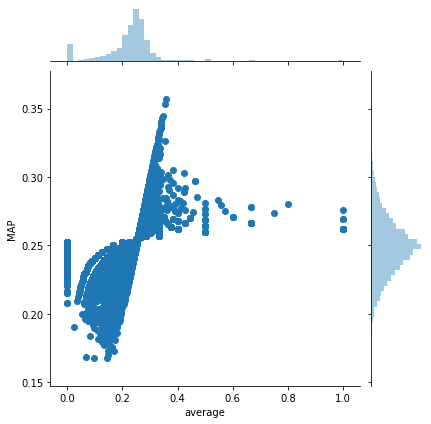

In [37]:
sns.jointplot('average', 'MAP', data=data);